# Segment a point cloud using a shapefile

In [1]:
import numpy as np 
import matplotlib.pyplot as plt


import cloudComPy as cc # cloud compare python interface.
if cc.isPluginCanupo():
    import cloudComPy.Canupo

if cc.isPluginPCL():
    import cloudComPy.PCL
from osgeo import gdal, ogr, osr
from subprocess import run

import json

from yaml import load
from yaml.loader import Loader

#from plotters import plotCavePlan

In [2]:
caveName = "GrotteDeVallorbe"

PROCESSING_FILEPATH = f"../../real_data/09_{caveName}/params.yaml"

params = load(open(PROCESSING_FILEPATH), Loader)


In [4]:
# load the processing parameters
f  = open(f"../../real_data/09_{caveName}/process/CropBoxes.geojson")
data = json.load(f)

shift = params['alignment']['globalShift']
polylineZ = 1500


In [5]:
# convert the polyline features to np.arrays
length_of_features = [len(feature["geometry"]["coordinates"][0][0]) for feature in data["features"]]

polylines = [np.zeros((n, 3)) for n in length_of_features]


In [6]:
for c,feature in enumerate(data["features"]):
    coords = np.array(feature["geometry"]["coordinates"][0][0])
    polylines[c][:,0:2] = coords
    polylines[c][:,2] = polylineZ



In [7]:
polylines[0]

array([[516387.68219015, 172099.45735724,   1500.        ],
       [516393.65046193, 172088.10785681,   1500.        ],
       [516396.7400703 , 172080.73492773,   1500.        ],
       [516389.82950398, 172078.88485486,   1500.        ],
       [516381.46127347, 172075.57243028,   1500.        ],
       [516377.11370585, 172089.95892677,   1500.        ],
       [516382.45110241, 172096.01328706,   1500.        ],
       [516387.68219015, 172099.45735724,   1500.        ]])

In [8]:
cc_polylines = []
for c, polyline in enumerate(polylines): 
    # create cloud from this and add to polyline object-
    boxCloud = cc.ccPointCloud("sectionAlongAxis")
    polyline_shifted = polyline + np.array(shift)
    boxCloud.coordsFromNPArray_copy(polyline_shifted)

    boxLine = cc.ccPolyline(boxCloud)
    boxLine.addChild(boxCloud)
    boxLine.addPointIndex(0, boxCloud.size())
    boxLine.setClosed(True)
    boxLine.setGlobalShift(*shift)
    cc_polylines.append(boxLine)

In [9]:
decimatedCloud = cc.loadPointCloud(f"../../real_data/09_{caveName}/output/{caveName}_subsampled_georef.las")

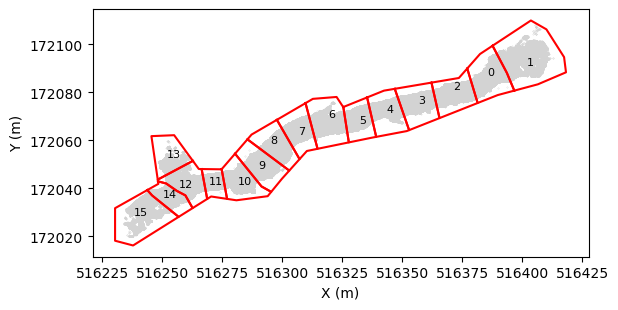

In [10]:
fig, ax = plt.subplots()

for c, line in enumerate(cc_polylines):
    xi = line.getAssociatedCloud().toNpArray()[:,0]
    yi = line.getAssociatedCloud().toNpArray()[:,1]
    centroid = line.getAssociatedCloud().computeGravityCenter()
    ax.plot(xi - shift[0], yi - shift[1], color = "r")
    ax.text(centroid[0]- shift[0], centroid[1] - shift[1], c,  ha = "center", va = "center", fontsize = 8)

ax.set_aspect("equal")
ax.scatter(decimatedCloud.toNpArray()[:,0]- shift[0], decimatedCloud.toNpArray()[:,1]- shift[1], s = 0.05, color = "lightgrey")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")

plt.show()

In [13]:
cloud = cc.loadPointCloud(f"../../real_data/09_{caveName}/output/{caveName}_georef.las")

In [14]:
cloud.size()

562385971

In [21]:
#polyline_3 = cc_polylines[2]

#CloudCropZ = cloud.crop2D(cc_polylines[3], 2, True)

In [22]:
#ret = cc.SavePointCloud(CloudCropZ, f"D:/ScanLeica/{caveName}/process/Cropped_3.ply")

In [17]:
# cycle through each polyline and cut the cloud, then save to a new ply file.  
for c, polyline in enumerate(cc_polylines): 

    # crop the cloud using the polyline, only leave stuff inside. 
    if c !=1:
        CloudCropZ = cloud.crop2D(polyline, 2, True) # 2 means that the viewing direction is parallel to Z axis and cropping is done from top view accordingly. 
        ret = cc.SavePointCloud(CloudCropZ, f"../../real_data/09_{caveName}/process/Cropped_{c}.ply")


for c, polyline in enumerate(polylines): 
    # create cloud from this and add to polyline object-
    boxCloud = cc.ccPointCloud("sectionAlongAxis")
    polyline_shifted = polyline + np.array(shift)
    boxCloud.coordsFromNPArray_copy(polyline_shifted)

    boxLine = cc.ccPolyline(boxCloud)
    boxLine.addChild(boxCloud)
    boxLine.addPointIndex(0, boxCloud.size())
    boxLine.setClosed(True)
    boxLine.setGlobalShift(*shift)
    print(boxLine.getBoundingBox())
    print(boxLine.getGlobalShift())
    CloudCropZ = cloud.crop2D(boxLine, 2, True)
    
    if CloudCropZ:
        #classify, clean,
        out = cc.Canupo.Classify(CloudCropZ, 
                    "../../ScanLeica/people_bedrock_classifier_10082023_strict_on_bedrock.prm", 
                   coreSource= cc.Canupo.CORE_CLOUD_SOURCES.SUBSAMPLED, 
                   samplingDist = 0.1)

        print(out)
        print(CloudCropZ.getScalarFieldDic())
        canupo_filter = CloudCropZ.getScalarField("CANUPO.class").toNpArray() == 2
        
        filtered_array = CloudCropZ.toNpArray()[canupo_filter]
        filtered_cloud = cc.ccPointCloud("Filtered")
        filtered_cloud.coordsFromNPArray_copy(filtered_array)

        print(filtered_cloud.size())
        
        # label connected components 
        cc.LabelConnectedComponents([filtered_cloud], octreeLevel = 6)
        print(filtered_cloud.getScalarFieldDic())

        cc_label_filter = filtered_cloud.getScalarField("CC labels").toNpArray() == 1 # filter to only get the zeroth, greatest connected component. 

        component_array = filtered_cloud.toNpArray()[cc_label_filter]
        greatest_component_cloud = cc.ccPointCloud("GreatestComponent")
        greatest_component_cloud.coordsFromNPArray_copy(component_array)
        greatest_component_cloud.computeOctree()
        print(greatest_component_cloud.size())
        if greatest_component_cloud.size() > 1e4:
            greatest_component_cloud.addScalarField("Index")
            greatest_component_cloud.getScalarField("Index").fill(c)
           
            ret = cc.SavePointCloud(greatest_component_cloud, f"D:/ScanLeica/{caveName}/process/Cropped_{c}.ply")
        else:
            unfiltered = cc.ccPointCloud("Unfiltered")
            unfiltered.coordsFromNPArray_copy(CloudCropZ.toNpArrayCopy())
            unfiltered.addScalarField("Index")
            unfiltered.getScalarField("Index").fill(c)
            ret = cc.SavePointCloud(unfiltered, f"D:/ScanLeica/{caveName}/process/Cropped_{c}.ply")

        radius = cc.GetPointCloudRadius(clouds=[greatest_component_cloud], nodes=10)
        print(radius)
        np.savetxt(f"D:/ScanLeica/{caveName}/process/CropBox{c}.poly", polyline)

